In [2]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


In [3]:
data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]


impl_volatility = 'impl_volatility_h_1_step'


test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers
# data_train = data_trains[data_trains['date'] < '2020-01-01']
# data_validate = data_trains[data_trains['date'] >= '2020-01-01']

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd
import joblib

def evaluate_params(params, train_x, train_y, val_data, IV, selected_features, verbose=0):
    """
    Perform walk-forward validation for a single set of hyperparameters with XGBoost.
    """
    if verbose >= 1:
        print(f"\nEvaluating parameters: {params}")

    xgb_model = XGBRegressor(random_state=42, **params)
    current_train_data_x = train_x.copy()
    current_train_data_y = train_y.copy()
    total_rmse = 0
    count = 0

    for date in pd.date_range(start='2020-01-01', end='2020-12-31'):
        # Filter validation data for the current day
        val_data_day = val_data[val_data['date'] == date]
        if val_data_day.empty:
            continue

        # Separate features and target for validation
        y_val = val_data_day[IV]
        X_val = val_data_day[selected_features]

        # Train the XGBRegressor on current training data with the specified parameters
        xgb_model.fit(current_train_data_x, current_train_data_y)

        # Predict on validation set for the current day
        y_pred = xgb_model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        total_rmse += rmse
        count += 1

        if verbose == 2:
            print(f"  Date: {date.date()}, RMSE: {rmse:.4f}")

        # Add the current day's validation data to the training set for the next iteration
        current_train_data_x = pd.concat([current_train_data_x, X_val])
        current_train_data_y = pd.concat([current_train_data_y, y_val])

    # Average RMSE for this parameter combination
    avg_rmse = total_rmse / count
    if verbose >= 1:
        print(f"Finished evaluating parameters: {params}, Average RMSE: {avg_rmse:.4f}")

    return params, avg_rmse

def walk_forward_validation_tuning_xgb(IV, data, selected_features, param_grid, verbose=0):
    """
    Perform Walk-Forward Validation for XGBoost hyperparameter tuning without scaling.
    """
    if verbose >= 1:
        print("Starting walk-forward validation tuning for XGBoost...")

    # Split the data into training (2019) and validation (2020)
    train_data = data[data['date'].dt.year == 2019]
    val_data = data[data['date'].dt.year == 2020]

    # Define features and target
    train_x = train_data[selected_features]
    train_y = train_data[IV]

    # Loop through each parameter combination
    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        _, avg_rmse = evaluate_params(params, train_x, train_y, val_data, IV, selected_features, verbose)

        # Update best parameters based on RMSE
        if avg_rmse < best_score:
            best_score = avg_rmse
            best_params = params

            if verbose >= 1:
                print(f"  New best parameters found: {best_params} with RMSE: {best_score:.4f}")

    print(f"Best hyperparameters found: {best_params} with average RMSE: {best_score:.4f}")
    return best_params

def retrain_final_model_xgb(IV, data, selected_features, best_params, verbose=0):
    """
    Retrain the final XGBoost model on combined 2019 and 2020 data with the best parameters.
    """
    if verbose >= 1:
        print("Retraining final XGBoost model on combined 2019 and 2020 data with best parameters...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Retrain XGBRegressor on the combined training and validation data with the best hyperparameters
    final_xgb_model = XGBRegressor(random_state=42, **best_params)
    final_xgb_model.fit(combined_x, combined_y)

    # Save the final model
    joblib.dump(final_xgb_model, 'final_xgb_model.pkl')
    
    print("Final model saved as 'final_xgb_model.pkl'.")
    return final_xgb_model

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [5, 7],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0]
# }

param_grid = {
    'max_depth': [5],                  
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample': [0.8]  # Added subsample to replace max_samples
}   

# Run the hyperparameter tuning without parallel processing
best_params = walk_forward_validation_tuning_xgb(impl_volatility, data, totalList, param_grid, verbose=2)

# Retrain the final model with the best parameters on the combined dataset
final_xgb_model = retrain_final_model_xgb(impl_volatility, data, totalList, best_params, verbose=1)


Starting walk-forward validation tuning for XGBoost...

Evaluating parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
  Date: 2020-01-02, RMSE: 0.0826
  Date: 2020-01-03, RMSE: 0.0655
  Date: 2020-01-06, RMSE: 0.0514
  Date: 2020-01-07, RMSE: 0.0828
  Date: 2020-01-08, RMSE: 0.1344
  Date: 2020-01-09, RMSE: 0.0617
  Date: 2020-01-10, RMSE: 0.1283
  Date: 2020-01-13, RMSE: 0.0491
  Date: 2020-01-14, RMSE: 0.0829
  Date: 2020-01-15, RMSE: 0.1015
  Date: 2020-01-16, RMSE: 0.0432
  Date: 2020-01-17, RMSE: 0.1409
  Date: 2020-01-21, RMSE: 0.1670
  Date: 2020-01-22, RMSE: 0.1149
  Date: 2020-01-23, RMSE: 0.3119
  Date: 2020-01-24, RMSE: 0.3468
  Date: 2020-01-27, RMSE: 0.1256
  Date: 2020-01-28, RMSE: 0.3087


KeyboardInterrupt: 

Retraining final XGBoost model on combined 2019 and 2020 data...


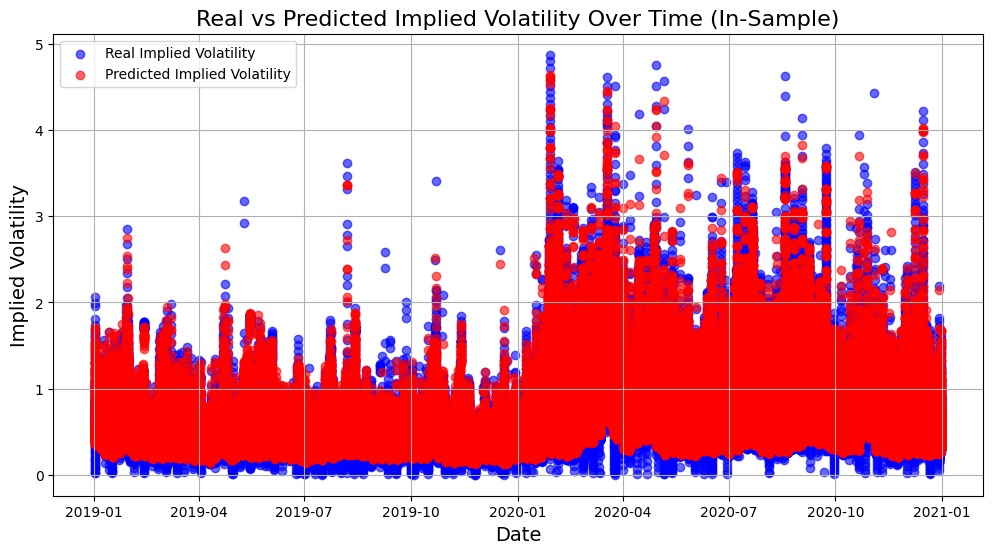

In-sample RMSE: 0.0697
In-sample R²: 0.9735


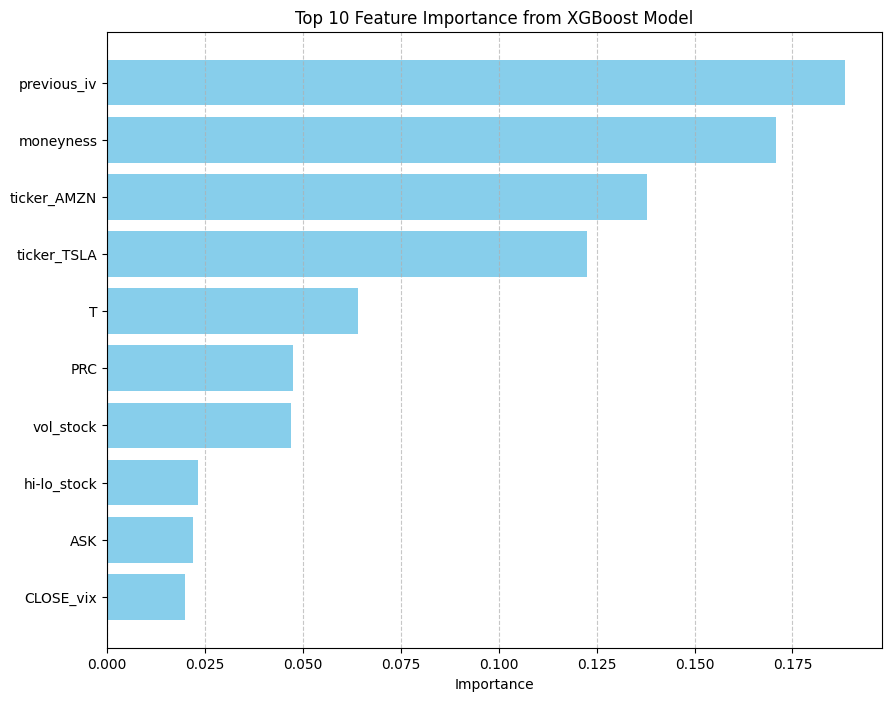

Final model and selected features have been saved.


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

def retrain_final_model_xgb(IV, data, selected_features, n_estimators, max_depth, learning_rate, subsample, random_state=42, verbose=0):
    """
    Retrain the final XGBoost model on combined 2019 and 2020 data with specified parameters
    and plot feature importance.
    """
    if verbose >= 1:
        print("Retraining final XGBoost model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Train XGBoost with the specified parameters
    final_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=random_state,
        objective='reg:squarederror'
    )
    final_model.fit(combined_x, combined_y)

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    # Extract feature importances
    importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Normalize importance so that the sum is 1
    importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

    # Select the top 10 features
    top_10_features_df = importance_df.head(10)

    # Plot the normalized importance of the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(top_10_features_df['Feature'], top_10_features_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance from XGBoost Model')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Save the final model and selected features
    joblib.dump(final_model, 'final_xgboost_model.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')

    print("Final model and selected features have been saved.")
    return final_model, top_10_features_df

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have defined n_estimators, max_depth, learning_rate, subsample, selected_features, and other relevant data
n_estimators = 150  # Example value; replace with the optimal value from your tuning
max_depth = 7     # Example value; replace with the optimal value from your tuning
learning_rate = 0.1 # Example value; replace with the optimal value from your tuning
subsample = 1     # Example value; replace with the optimal value from your tuning

# Retrain the final model on the combined dataset and plot top 10 normalized features
final_xgb_model, selected_features_final = retrain_final_model_xgb(
    impl_volatility, data, totalList, n_estimators, max_depth, learning_rate, subsample, verbose=1
)


In [19]:
selected_features_final['Importance'].to_list()

[0.2944496273994446,
 0.22215673327445984,
 0.15042999386787415,
 0.07288922369480133,
 0.07207909226417542,
 0.03044576197862625,
 0.02159697748720646,
 0.014257044531404972,
 0.013119528070092201,
 0.01307588815689087]

AAPL RMSE: 0.1131996155271549
AAPL R²: 0.5630788240709821


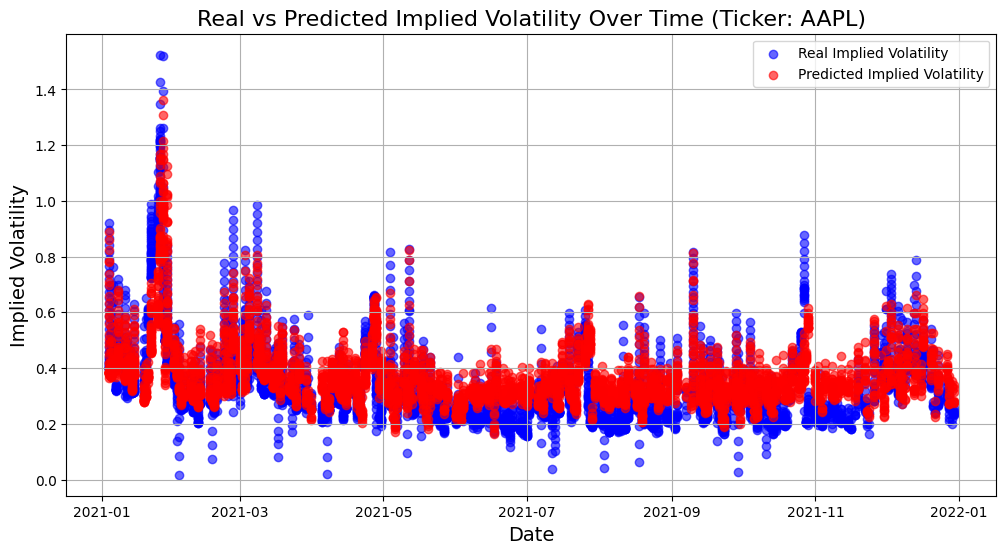

AMZN RMSE: 0.11531223419395661
AMZN R²: 0.7903489216806301


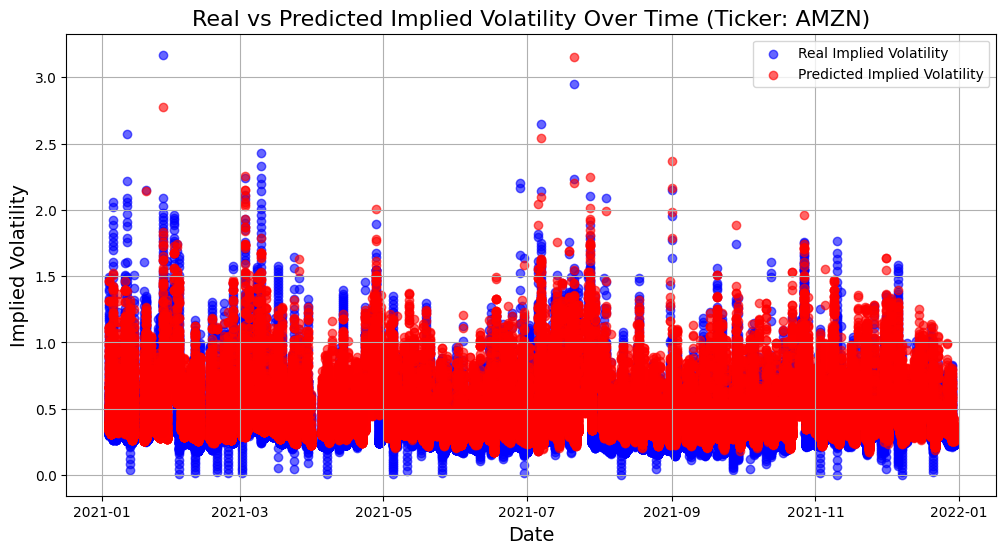

NVDA RMSE: 0.16980744179336704
NVDA R²: 0.7098786562690294


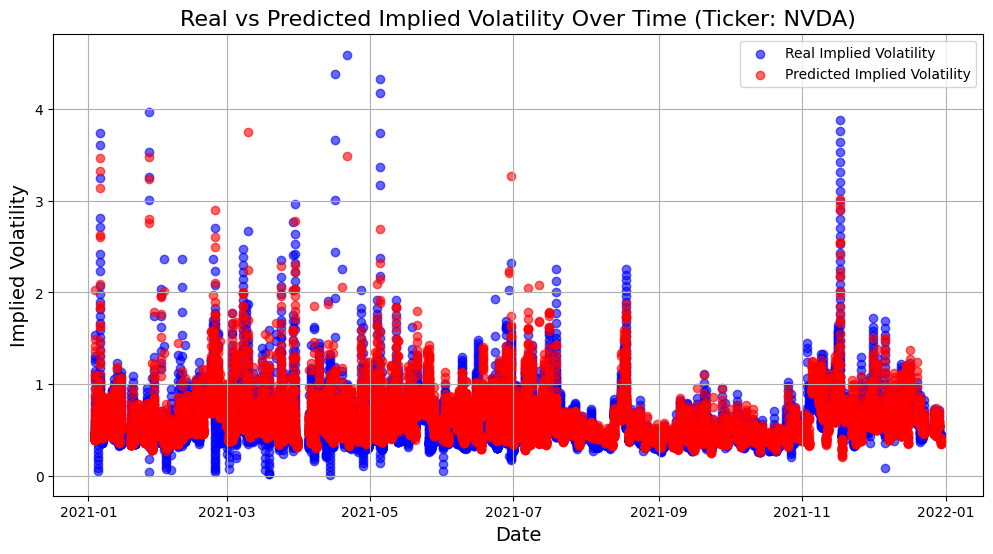

TSLA RMSE: 0.20741959099615606
TSLA R²: 0.773464280118535


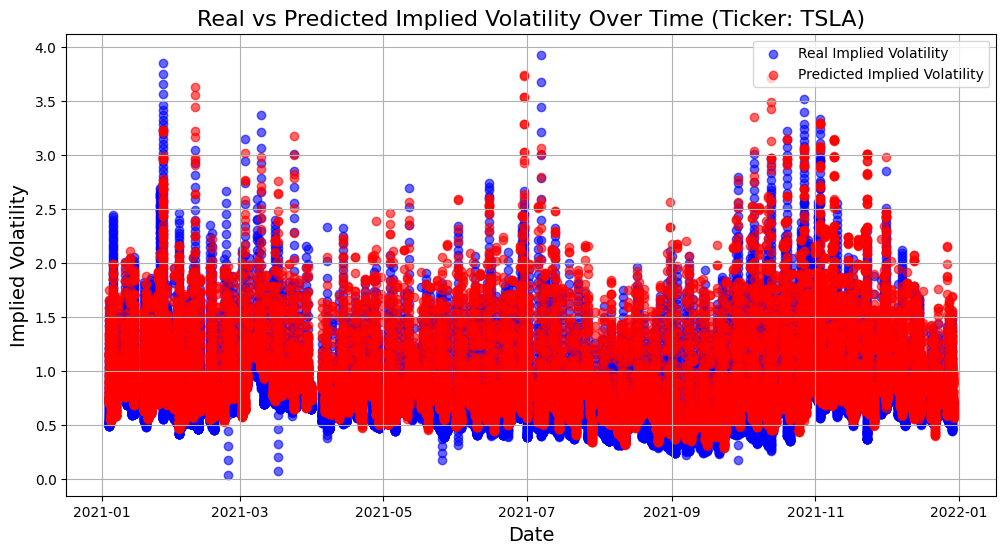

META RMSE: 0.11477801187958904
META R²: 0.6743853153994279


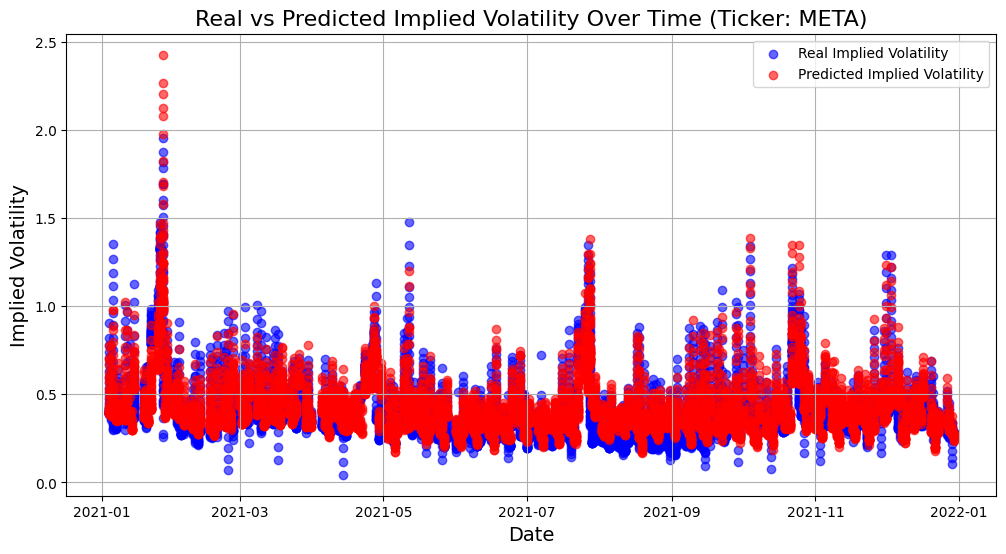

MSFT RMSE: 0.08906210956919805
MSFT R²: 0.594858278546597


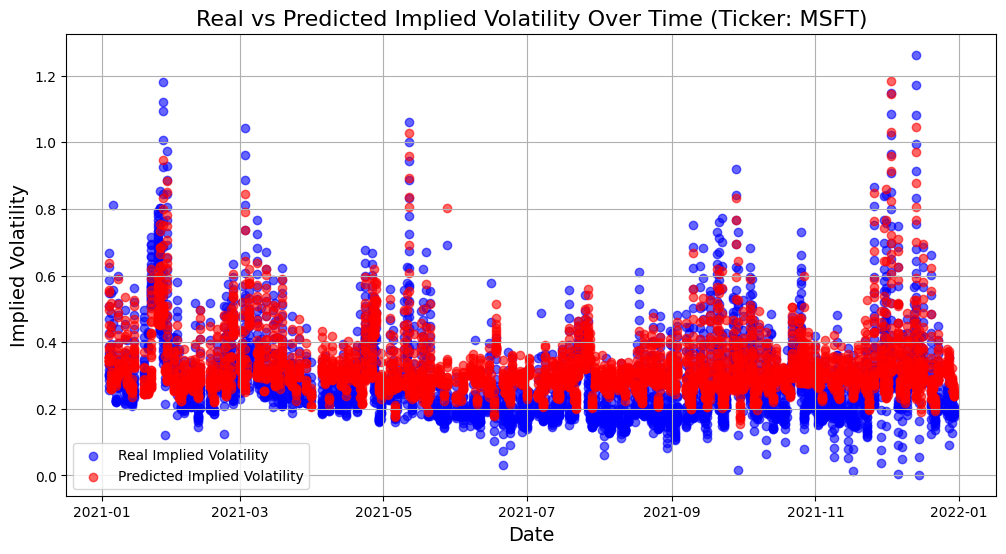

Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.004739604520487448
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/xgb_all.csv
Manually Calculated Combined R²: 0.8277128068378452
Overall Weighted RMSE: 0.14767779524185962
Overall Weighted R²: 0.7503931069893376
Overall Combined RMSE: 0.1476777952418596
Overall Combined R²: 0.8277128068378452
XGBoost Overall Weighted RMSE: 0.14767779524185962
XGBoost Overall Weighted R²: 0.7503931069893376
XGBoost Overall Combined RMSE: 0.1476777952418596
XGBoost Overall Combined R²: 0.8277128068378452
XGBoost Ticker-Specific Results:
{'Ticker': 'AAPL', 'RMSE': 0.1131996155271549, 'R²': 0.5630788240709821}
{'Ticker': 'AMZN', 'RMSE': 0.11531223419395661, 'R²': 0.7903489216806301}
{'Ticker': 'NVDA', 'RMSE': 0.16980744179336704, 'R²': 0.7098786562690294}
{'Ticker': 'TSLA', 'RMSE': 0.20741959

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_per_ticker(IV, test_data, model, selected_features):
    """
    Predict the target variable for the test set using the trained model,
    calculate RMSE and R² for each ticker, and compute weighted and combined overall metrics.

    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained model (e.g., Random Forest or XGBoost).
    selected_features (list): The list of features used for modeling.

    Returns:
    dict: Contains RMSE and R² values for each ticker, overall weighted metrics, 
          and combined overall metrics.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()

    # Initialize accumulators for overall RMSE and R²
    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

    # Collect all actual and predicted values for combined metrics
    combined_actual = []
    combined_predicted = []

    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]

        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]

        # Predict implied volatility using the trained model
        y_ticker_pred = model.predict(X_ticker)

        # Collect predictions and actual values for combined calculation
        combined_actual.extend(y_ticker_actual)
        combined_predicted.extend(y_ticker_pred)

        # Calculate RMSE and R² for the ticker-specific implied volatility prediction
        rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
        r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

        # Calculate the number of observations for the ticker
        num_observations = len(y_ticker_actual)

        # Weighted summing for overall RMSE and R²
        total_rmse_weighted_sum += num_observations * rmse_ticker**2
        total_r2_weighted_sum += num_observations * r2_ticker
        total_observations += num_observations

        # Save results for this ticker
        results_list_all.append({
            'Ticker': ticker,
            'RMSE': rmse_ticker,
            'R²': r2_ticker
        })
        print(f'{ticker} RMSE: {rmse_ticker}')
        print(f'{ticker} R²: {r2_ticker}')

        # Plot Real vs Predicted values for the ticker
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall weighted RMSE and R²
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    # Calculate combined overall RMSE and R² using all data
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)

    errors_test = combined_actual - combined_predicted
    test_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in test_data.columns:
        daily_avg_errors = test_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/xgb_all.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    # Calculate mean implied volatility for all test set observations
    mean_iv = np.mean(combined_actual)
    
    # Manually calculate combined R² for validation
    numerator = np.sum((combined_actual - combined_predicted) ** 2)
    denominator = np.sum((combined_actual - mean_iv) ** 2)
    combined_r2_manual = 1 - (numerator / denominator)
    print(f"Manually Calculated Combined R²: {combined_r2_manual}")


    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')
    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    return {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2,
        'Overall_Combined_RMSE': overall_combined_rmse,
        'Overall_Combined_R²': overall_combined_r2
    }

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for Random Forest or XGBoost
# Assuming `datat` (test data), `final_xgb_model` (trained XGBoost model), and `totalList` (features) are defined
results_xgb = predict_test_data_per_ticker(impl_volatility, datat, final_xgb_model, totalList)

# Print overall weighted metrics
print(f"XGBoost Overall Weighted RMSE: {results_xgb['Overall_RMSE']}")
print(f"XGBoost Overall Weighted R²: {results_xgb['Overall_R²']}")
print(f"XGBoost Overall Combined RMSE: {results_xgb['Overall_Combined_RMSE']}")
print(f"XGBoost Overall Combined R²: {results_xgb['Overall_Combined_R²']}")

# Print ticker-specific results for XGBoost
print("XGBoost Ticker-Specific Results:")
for ticker_result in results_xgb['Ticker_Results']:
    print(ticker_result)


Baseline R² (OOS): 0.8277
Feature: moneyness, Baseline R²: 0.8277, Perturbed R²: -1.5977, Absolute Change: 2.4254
Feature: T, Baseline R²: 0.8277, Perturbed R²: 0.6414, Absolute Change: 0.1863
Feature: 2Y_bond, Baseline R²: 0.8277, Perturbed R²: 0.8264, Absolute Change: 0.0013
Feature: FF_rate, Baseline R²: 0.8277, Perturbed R²: 0.6645, Absolute Change: 0.1632
Feature: gold_price, Baseline R²: 0.8277, Perturbed R²: 0.8274, Absolute Change: 0.0003
Feature: reces_indi, Baseline R²: 0.8277, Perturbed R²: 0.8324, Absolute Change: 0.0047
Feature: CLOSE_vix, Baseline R²: 0.8277, Perturbed R²: 0.8331, Absolute Change: 0.0054
Feature: hi-lo_vix, Baseline R²: 0.8277, Perturbed R²: 0.8246, Absolute Change: 0.0031
Feature: cp_flag, Baseline R²: 0.8277, Perturbed R²: 0.8338, Absolute Change: 0.0061
Feature: spread_option, Baseline R²: 0.8277, Perturbed R²: 0.8292, Absolute Change: 0.0014
Feature: volume, Baseline R²: 0.8277, Perturbed R²: 0.8241, Absolute Change: 0.0036
Feature: prc_option, Baseli

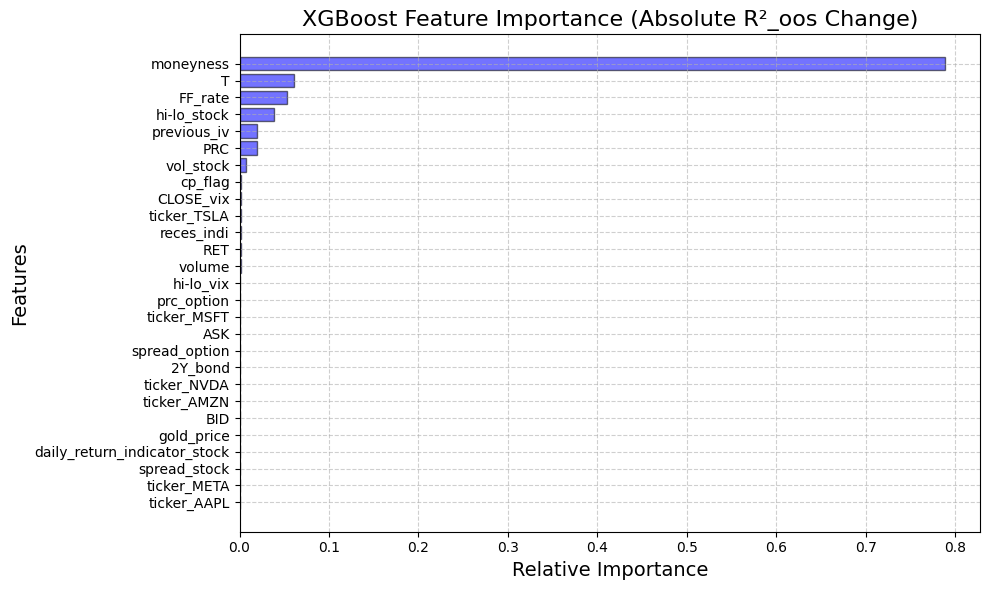

In [12]:
def calculate_feature_importance_r2_xgb(data_test, features, target, model):
    """
    Calculate feature importance for XGBoost based on the absolute change in R²_oos when a feature is set to zero.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained XGBoost model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Predict on the test data and calculate baseline R²_oos
    X_test = data_test[features]
    y_test = data_test[target]
    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the absolute change in R²_oos for each feature
    r2_changes = []
    for feature in features:
        # Perturb the test data by setting the feature to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed)
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_change = abs(baseline_r2 - r2_zeroed)  # Use absolute change
        r2_changes.append(r2_change)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_changes)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all changes are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example Usage
# Assuming `datat` is the test dataset, `final_xgb_model` is the trained XGBoost model, and `totalList` contains feature names.

# Calculate feature importance for XGBoost based on R²_oos
feature_importance_xgb, baseline_r2_xgb = calculate_feature_importance_r2_xgb(
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=final_xgb_model
)

# Print and visualize the feature importance
print("Feature Importance (Absolute R²_oos Change) for XGBoost:")
print(feature_importance_xgb)

plot_feature_importance(feature_importance_xgb, title="XGBoost Feature Importance (Absolute R²_oos Change)")


In [14]:
# feature_importance_xgb["Importance"].tolist()
feature_importance_xgb["Feature"].tolist()

['moneyness',
 'T',
 'FF_rate',
 'hi-lo_stock',
 'previous_iv',
 'PRC',
 'vol_stock',
 'cp_flag',
 'CLOSE_vix',
 'ticker_TSLA',
 'reces_indi',
 'RET',
 'volume',
 'hi-lo_vix',
 'prc_option',
 'ticker_MSFT',
 'ASK',
 'spread_option',
 '2Y_bond',
 'ticker_NVDA',
 'ticker_AMZN',
 'BID',
 'gold_price',
 'daily_return_indicator_stock',
 'spread_stock',
 'ticker_META',
 'ticker_AAPL']

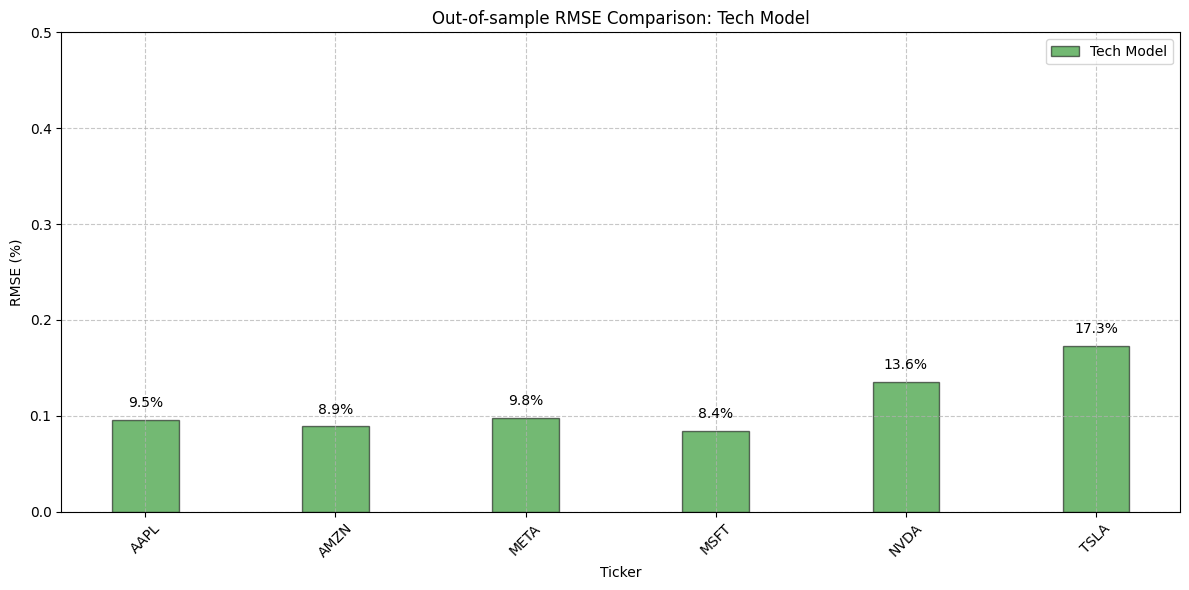

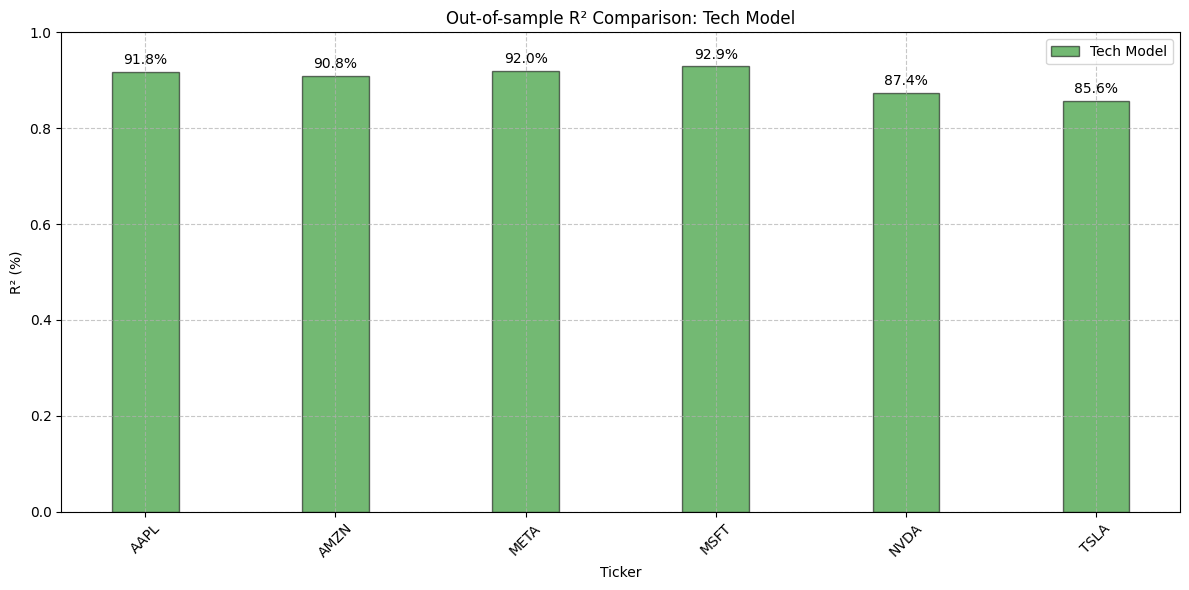

In [52]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 1])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Overall RMSE: 0.11823136066386895
Overall R²: 0.906058471747239


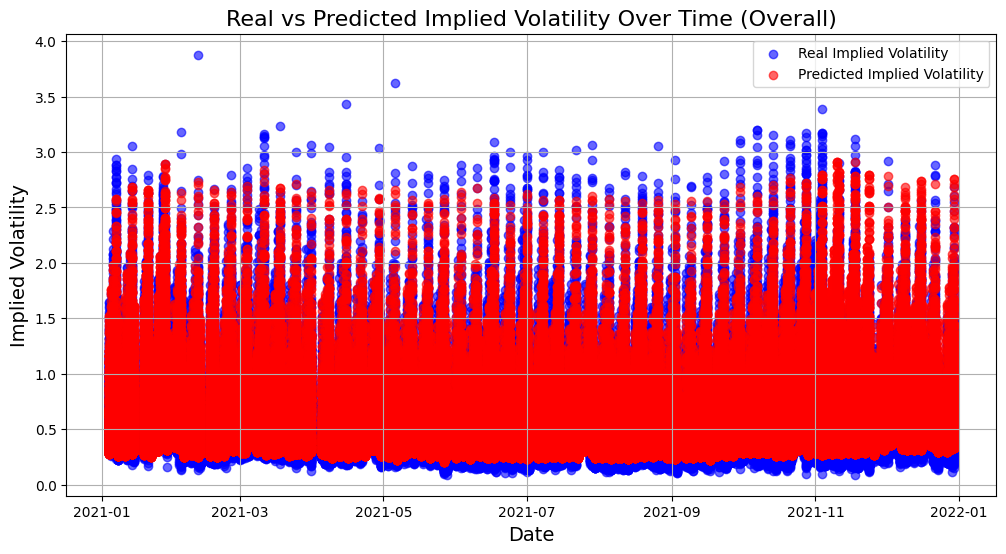

In [43]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load the saved model, scaler, and hyperparameters
final_model = joblib.load('final_rf_model.pkl')

def predict_test_data_all_tickers(IV, test_data, model, selected_features):
    """
    Predict the target variable for the test set using the trained model and calculate overall RMSE and R².
    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained model.
    selected_features (list): The list of features used for prediction.
    Returns:
    dict: Overall RMSE and R² values for the test set.
    """
    # Separate features and target for the entire test set
    y_actual = test_data[IV]
    X = test_data[selected_features]
    
    # Predict implied volatility using the trained model
    y_pred = model.predict(X)

    # Calculate overall RMSE and R² for the test set
    overall_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    overall_r2 = r2_score(y_actual, y_pred)
    
    print(f'Overall RMSE: {overall_rmse}')
    print(f'Overall R²: {overall_r2}')

    plot_real_vs_predicted(test_data, y_actual, y_pred, 'Overall')

    return {'Overall RMSE': overall_rmse, 'Overall R²': overall_r2}

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Predict and calculate overall RMSE and R² for the test set
overall_results = predict_test_data_all_tickers('impl_volatility', datat, final_xgb_model, totalList)


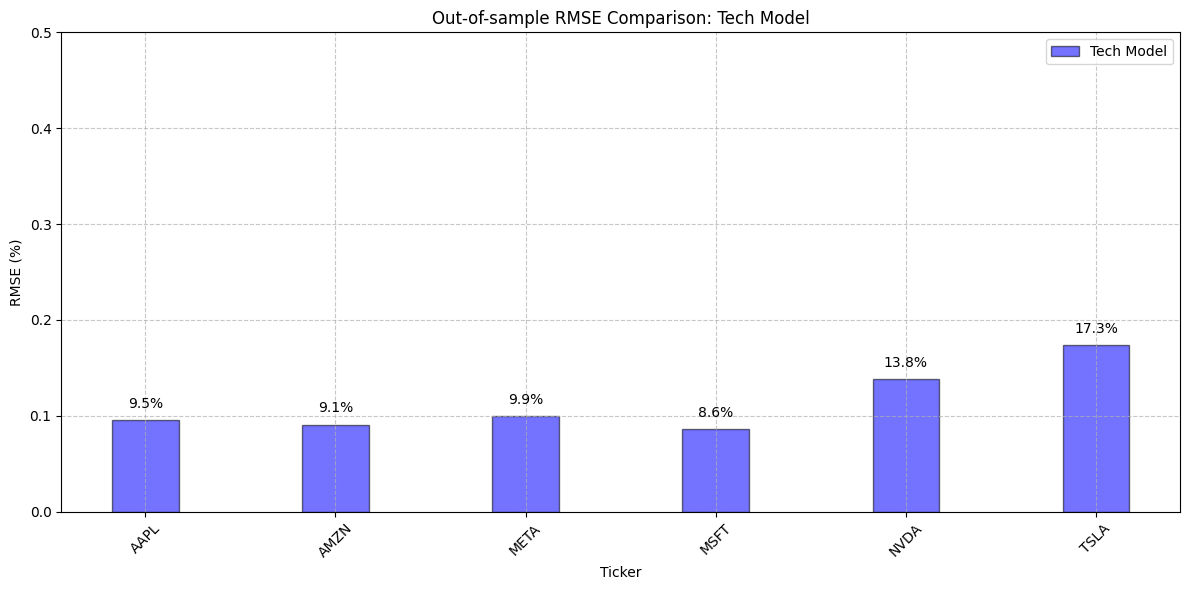

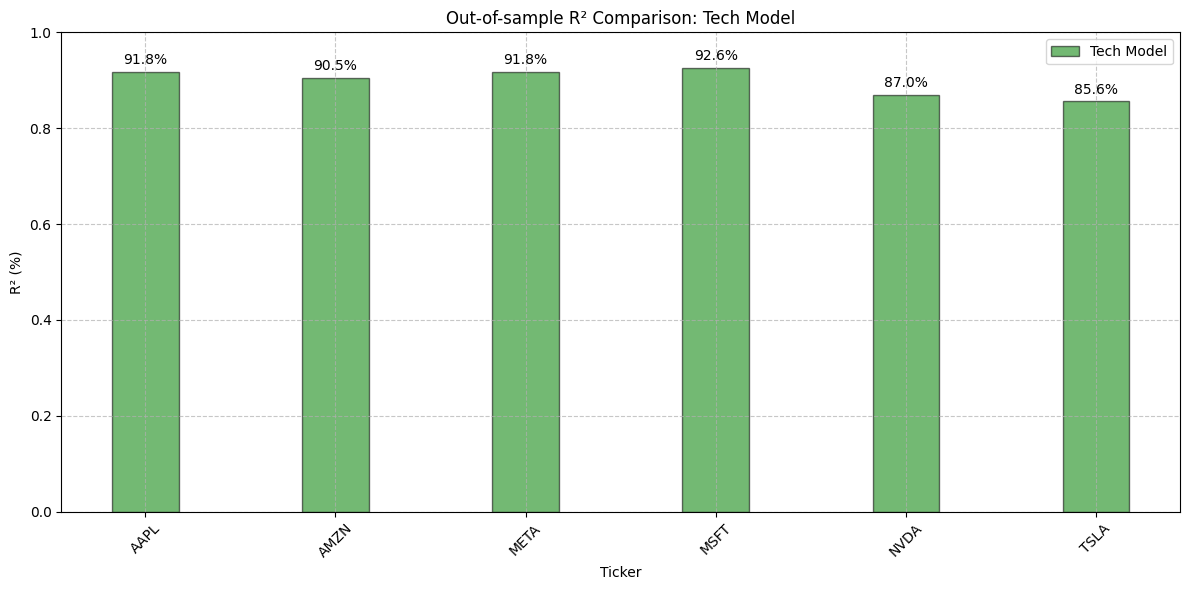

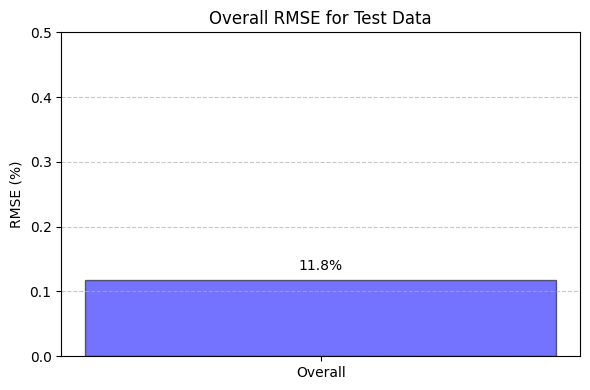

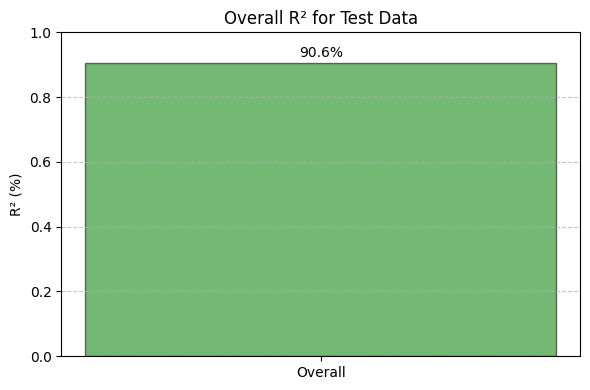

In [47]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='blue', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 1])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Plot overall RMSE and R²
overall_results_df = pd.DataFrame([overall_results])

# Plot overall RMSE
plt.figure(figsize=(6, 4))
bars_overall_rmse = plt.bar(['Overall'], overall_results_df['Overall RMSE'], color='blue', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_overall_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.ylabel('RMSE (%)')
plt.title('Overall RMSE for Test Data')
plt.ylim([0, 0.5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot overall R²
plt.figure(figsize=(6, 4))
bars_overall_r2 = plt.bar(['Overall'], overall_results_df['Overall R²'], color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_overall_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.ylabel('R² (%)')
plt.title('Overall R² for Test Data')
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()